In [281]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import json

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [5.0, 3.0]
plt.rcParams['figure.dpi'] = 150
%matplotlib notebook

In [326]:
country_name = "india";
dir_path = "../C++/build/release/results/" + country_name + "_2layer_14d_iter5k_pass100_constant/";
true_data = pd.read_csv(dir_path + country_name + ".txt",sep=' ', skipinitialspace=True, \
                        skiprows=1, header=None, names=['confirmed', 'recovered', 'deaths'])
print(true_data)

start_date_map = {
    "india"         : "2020-01-30",
    "southafrica"   : "2020-03-01",
    "srilanka"      : "2020-10-01",
    "unitedkingdom" : "2020-01-31",
    "unitedstates"  : "2020-01-22",
}

start_date = datetime.strptime(start_date_map[country_name], "%Y-%m-%d")
print(start_date_map[country_name])

     confirmed  recovered  deaths
0            1          0       0
1            1          0       0
2            1          0       0
3            2          0       0
4            3          0       0
..         ...        ...     ...
756   42894345          0  513226
757   42905844          0  513481
758   42916117          0  513724
759   42924130          0  513843
760   42931045          0  514023

[761 rows x 3 columns]
2020-01-30


In [327]:
smoothed_data = pd.read_csv(dir_path + country_name + "_popsmooth.txt", skipinitialspace=True, \
                            header=None, names=['confirmed_true', 'deaths_true', 'confirmed_smooth', 'deaths_smooth', 'vaccine_smooth', 'tests_smooth'])
diff_data = smoothed_data.diff();
diff_data.loc[0] = 0
smoothed_data

,confirmed_true,deaths_true,confirmed_smooth,deaths_smooth,vaccine_smooth,tests_smooth
0,1,0,1,0,0,0
1,1,0,1,0,0,0
2,1,0,2,0,0,0
3,2,0,2,0,0,0
4,3,0,2,0,0,0
...,...,...,...,...,...,...
756,42894345,513226,42891511,513166,782452452,763346013
757,42905844,513481,42902813,513406,784702138,764393872
758,42916117,513724,42914296,513659,787107516,765422502
759,42924130,513843,42923764,513863,789380961,766658059


<IPython.core.display.Javascript object>


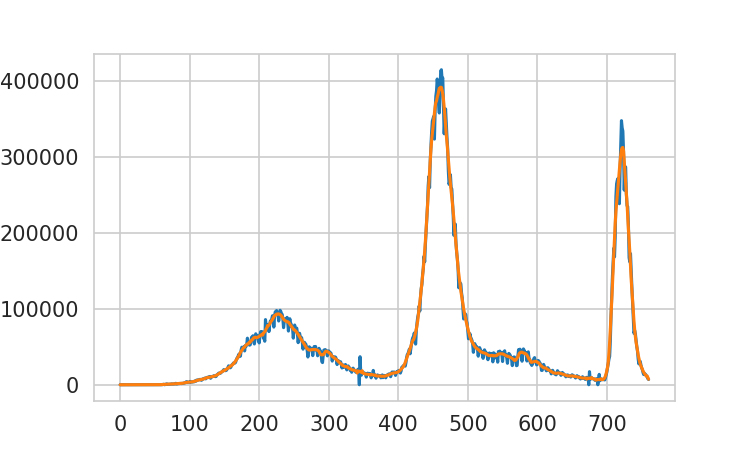

In [328]:
plt.figure()
plt.plot(diff_data['confirmed_true'])
plt.plot(diff_data['confirmed_smooth'])
plt.show()

<IPython.core.display.Javascript object>


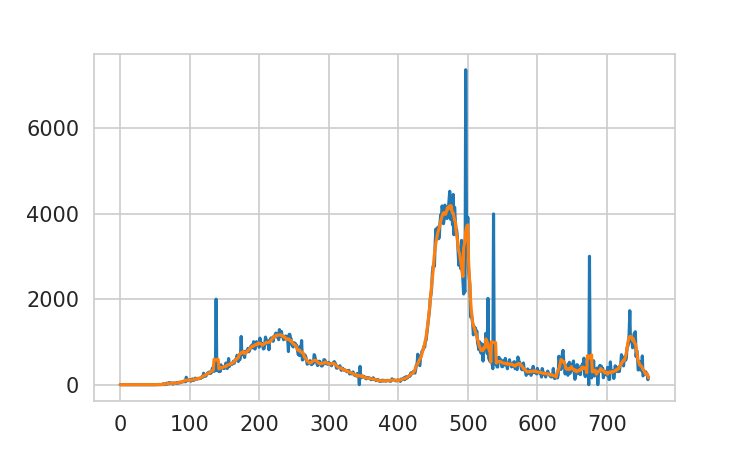

In [329]:
plt.figure()
plt.plot(diff_data['deaths_true'])
plt.plot(diff_data['deaths_smooth'])
plt.show()

<IPython.core.display.Javascript object>


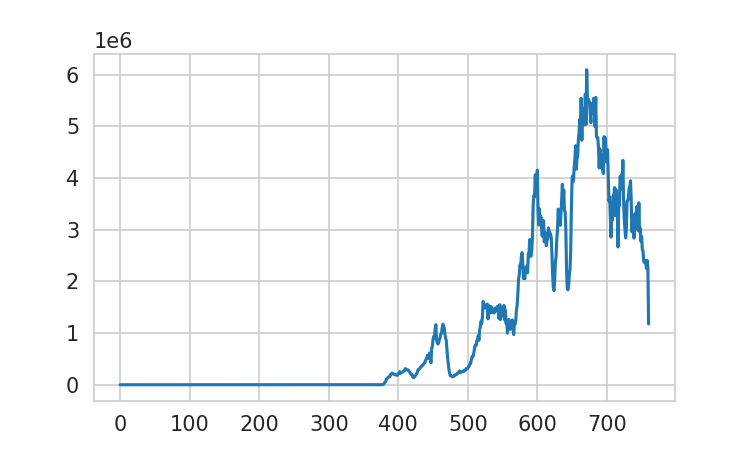

In [330]:
plt.figure()
plt.plot(diff_data['vaccine_smooth'])
plt.show()

<IPython.core.display.Javascript object>


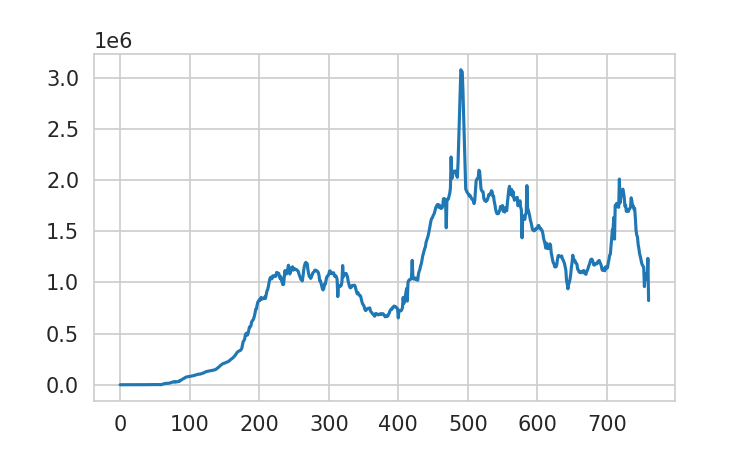

In [331]:
plt.figure()
plt.plot(diff_data['tests_smooth'])
plt.show()

In [332]:
pred_data = pd.read_csv(dir_path + country_name + "_prediction_seed1.txt", \
                        skipinitialspace=True)
# print("pred_data:\n", pred_data)
num_days = len(pred_data)
print("Num days:", num_days)

param_data = pd.read_csv(dir_path + country_name + "_params_seed1.txt", \
                        skipinitialspace=True,header=None)
# param_data = param_data.iloc[:, ::-1];
#print(param_data)

beta = param_data.loc[0:num_days-1]
IFR  = param_data.loc[num_days:2*num_days-1]

num_sol_to_plot = min(20, len(param_data.columns));

T_incub = param_data.loc[param_data.index[-7]]
T_recov = param_data.loc[param_data.index[-6]]
beta_test_scaling = param_data.loc[param_data.index[-5]]
beta_vac_scaling = param_data.loc[param_data.index[-4]]
vaccine_alpha = param_data.loc[param_data.index[-3]]
IFR_scaling = param_data.loc[param_data.index[-2]]
#print("Vaccine effectiveness:\n",vaccine_eff)

print("T_incub:\n", T_incub)
print("T_recov:\n", T_recov)
print("beta_test_scaling:\n", beta_test_scaling)
print("beta_vac_scaling:\n", beta_vac_scaling)
print("vaccine_alpha:\n", vaccine_alpha)
print("IFR_scaling:\n", IFR_scaling)

optimal_params = {
    "beta": beta[0].tolist(),
    "IFR"  : IFR[0].tolist(),
    "T_incub": T_incub[0],
    "T_recov": T_recov[0],
    "beta_test_scaling": beta_test_scaling[0],
    "beta_vac_scaling": beta_vac_scaling[0],
    "vaccine_alpha": vaccine_alpha[0],
    "IFR_scaling": IFR_scaling[0]
}

#Write optimal parameters as JS variable
opt_param_json_file = open("optimal_parameters.js", "w")
opt_param_json_file.write("let optimal_model_params = ")
json.dump(optimal_params, opt_param_json_file)
opt_param_json_file.close()

error = param_data.loc[param_data.index[-1]]
error_plot = error[0:num_sol_to_plot]
print("Error:\n",error)

scaled_error = (np.log(error_plot) - np.log(min(error_plot))) / (np.log(max(error_plot)) - np.log(min(error_plot))) * 0.9
print("Scaled error:\n", scaled_error)
grey_colors = np.tile(scaled_error,[3,1]).transpose();

# grey_colormap = matplotlib.colors.ListedColormap(grey_colors)
grey_colors[0] = [0.24, 0.63, 0.93] #Change color of best result to blue
print("Grey colors:\n", grey_colors)
# plt.figure()
# ax = sns.heatmap(np.random.rand(30,30))
# ax.pcolor(np.random.rand(30,30),cmap=grey_colormap)
# plt.show()

dates = [];
for i in range(0,num_days):
    dates.append(start_date + timedelta(days=i))

locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)

Num days: 761
T_incub:
 0     4.697782
1     9.148833
2     8.969505
3     8.949271
4     7.293197
        ...   
95    3.043839
96    2.659096
97    3.982835
98    5.824276
99    7.114475
Name: 1522, Length: 100, dtype: float64
T_recov:
 0     14.000000
1     12.140600
2     13.996930
3     11.637070
4     11.559890
        ...    
95     3.404106
96     5.516938
97     4.662654
98     7.120257
99     7.876823
Name: 1523, Length: 100, dtype: float64
beta_test_scaling:
 0     0.458651
1     0.694093
2     1.000000
3     0.568367
4     0.779258
        ...   
95    0.735117
96    0.865716
97    0.122228
98    0.245038
99    0.889342
Name: 1524, Length: 100, dtype: float64
beta_vac_scaling:
 0     1.000000
1     0.128339
2     0.403300
3     0.123598
4     0.629309
        ...   
95    0.962871
96    0.073123
97    0.629671
98    0.023169
99    0.874510
Name: 1525, Length: 100, dtype: float64
vaccine_alpha:
 0     1.000000
1     0.203748
2     0.509143
3     0.225713
4     0.185841
     

<IPython.core.display.Javascript object>


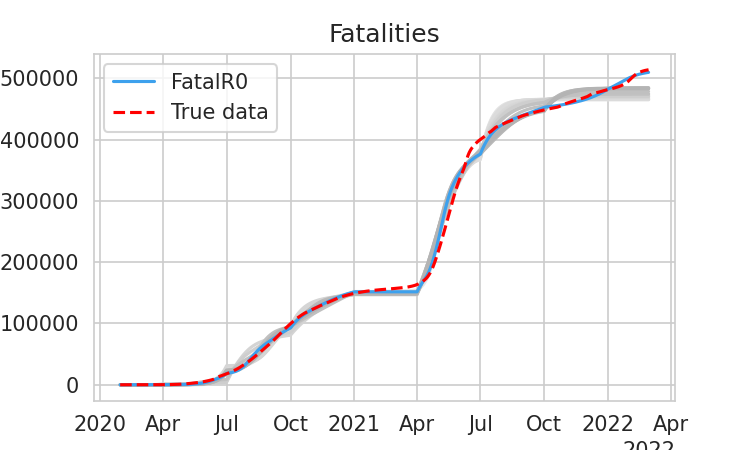

In [333]:
pred_fatal = pred_data.filter(regex=("FatalR.*"))

fig = plt.figure()

for i in range(num_sol_to_plot-1,0,-1):
    plt.plot(dates,pred_fatal["FatalR"+str(i)], color=grey_colors[i])
plt.plot(dates,pred_fatal["FatalR"+str(0)], color=grey_colors[0], label=pred_fatal.columns[0])
    
plt.plot(dates,smoothed_data["deaths_smooth"],'r--',label='True data')
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
    
# labels = pred_fatal.columns[0:num_sol_to_plot][::-1].tolist();
# labels.append("True data");
plt.legend(loc='upper left')
plt.title('Fatalities')
plt.show()


<IPython.core.display.Javascript object>


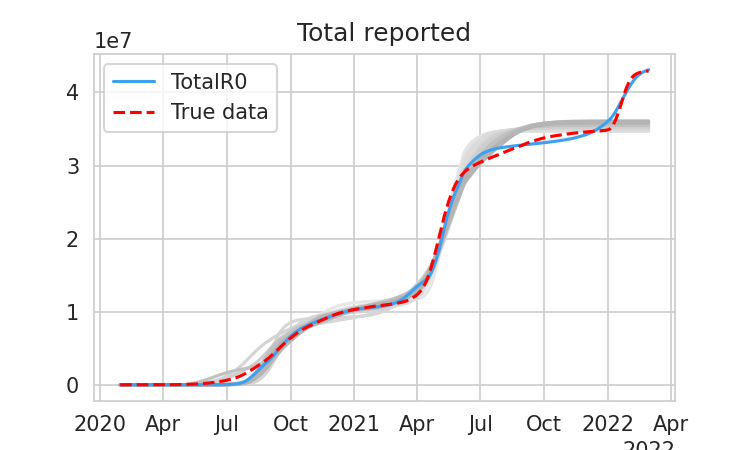

In [334]:
pred_reported = pred_data.filter(regex=("TotalR.*"))
# print(pred_reported)

plt.figure()

for i in range(num_sol_to_plot-1,0,-1):
    plt.plot(dates, pred_reported["TotalR"+str(i)], color=grey_colors[i])
plt.plot(dates, pred_reported["TotalR"+str(0)], color=grey_colors[0], label=pred_reported.columns[0])

# plt.plot(pred_reported)
plt.plot(dates, smoothed_data["confirmed_smooth"],'r--',label='True data')
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# labels = pred_reported.columns[0:num_sol_to_plot][::-1].tolist();
# labels.append("True data");
plt.legend(loc='upper left')
plt.title('Total reported')
plt.show()

<IPython.core.display.Javascript object>


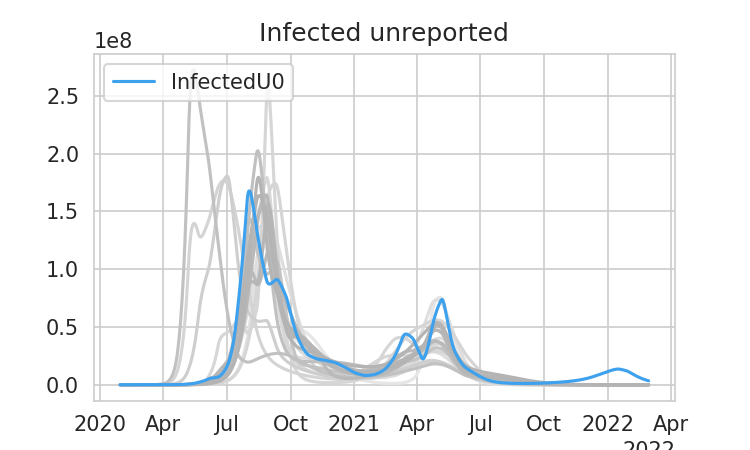

In [335]:
pred_reported = pred_data.filter(regex=("InfectedU.*"))
# print(pred_reported)

plt.figure()

for i in range(num_sol_to_plot-1,0,-1):
    plt.plot(dates, pred_reported["InfectedU"+str(i)], color=grey_colors[i])
plt.plot(dates, pred_reported["InfectedU"+str(0)], color=grey_colors[0], label=pred_reported.columns[0])

# plt.plot(dates, smoothed_data["confirmed_smooth"],'r--')
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# labels = pred_reported.columns[0:num_sol_to_plot][::-1].tolist();
# labels.append("True data");
plt.legend(loc='upper left')
plt.title('Infected unreported')
plt.show()

       TotalVac0    TotalVac1    TotalVac2    TotalVac3    TotalVac4  \
0            0.0          0.0          0.0          0.0          0.0   
1            0.0          0.0          0.0          0.0          0.0   
2            0.0          0.0          0.0          0.0          0.0   
3            0.0          0.0          0.0          0.0          0.0   
4            0.0          0.0          0.0          0.0          0.0   
..           ...          ...          ...          ...          ...   
756  780099435.0  780099435.0  780099435.0  780099435.0  780099435.0   
757  782452452.0  782452452.0  782452452.0  782452452.0  782452452.0   
758  784702138.0  784702138.0  784702138.0  784702138.0  784702138.0   
759  787107516.0  787107516.0  787107516.0  787107516.0  787107516.0   
760  789380961.0  789380961.0  789380961.0  789380961.0  789380961.0   

       TotalVac5    TotalVac6    TotalVac7    TotalVac8    TotalVac9  ...  \
0            0.0          0.0          0.0          0.0   

<IPython.core.display.Javascript object>


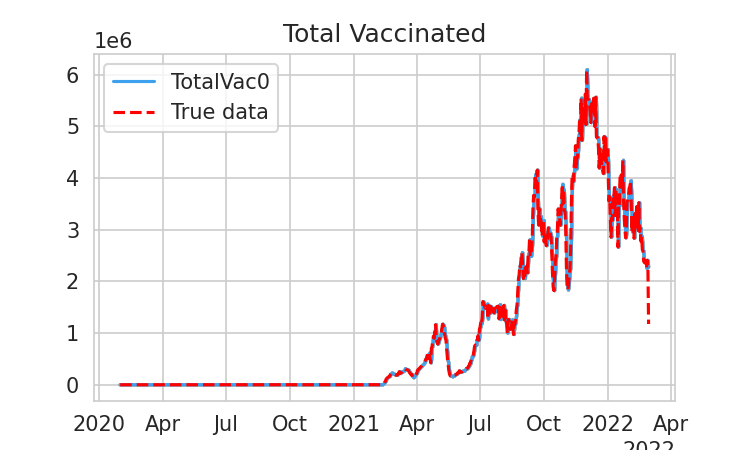

In [336]:
pred_vaccine = pred_data.filter(regex=("TotalVac.*"))
print(pred_vaccine)

plt.figure()

for i in range(num_sol_to_plot-1,0,-1):
    plt.plot(dates, pred_vaccine["TotalVac"+str(i)].diff(), color=grey_colors[i])
plt.plot(dates, pred_vaccine["TotalVac"+str(0)].diff(), color=grey_colors[0], label=pred_vaccine.columns[0])

# plt.plot(pred_reported)
plt.plot(dates, smoothed_data["vaccine_smooth"].diff(),'r--',label='True data')
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# labels = pred_vaccine.columns[0:num_sol_to_plot][::-1].tolist();
# labels.append("True data");
plt.legend(loc='upper left')
plt.title('Total Vaccinated')
plt.show()

<IPython.core.display.Javascript object>


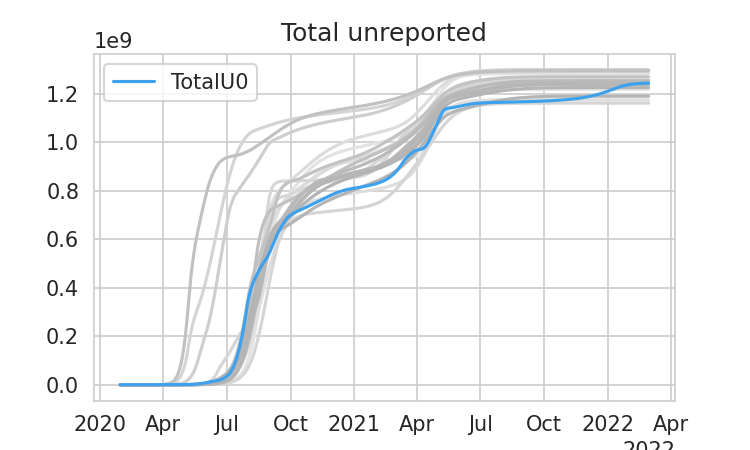

In [337]:
pred_unreported = pred_data.filter(regex=("TotalU.*"))
# print(pred_unreported)

plt.figure()

for i in range(num_sol_to_plot-1,0,-1):
    plt.plot(dates, pred_unreported["TotalU"+str(i)], color=grey_colors[i])
plt.plot(dates, pred_unreported["TotalU"+str(0)], color=grey_colors[0], label=pred_unreported.columns[0])

ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# labels = pred_unreported.columns[0:num_sol_to_plot][::-1].tolist();
plt.legend(loc='upper left')
plt.title('Total unreported')
plt.show()

        Reff0     Reff1     Reff2     Reff3     Reff4     Reff5     Reff6  \
0    3.595552  3.495110  3.557329  3.939074  3.137928  3.356724  4.105345   
1    3.595552  3.495110  3.557329  3.939074  3.137928  3.356724  4.105345   
2    3.595552  3.495110  3.557329  3.939074  3.137928  3.356724  4.105345   
3    3.595552  3.495110  3.557329  3.939074  3.137928  3.356724  4.105345   
4    3.595552  3.495109  3.557329  3.939074  3.137928  3.356724  4.105345   
..        ...       ...       ...       ...       ...       ...       ...   
756  0.308861  0.052845  0.081751  0.055610  0.067969  0.045197  0.090291   
757  0.309198  0.054840  0.083384  0.057750  0.069493  0.045669  0.091892   
758  0.309206  0.051233  0.080567  0.053944  0.066735  0.044949  0.089129   
759  0.302268  0.053509  0.082056  0.056299  0.067989  0.044856  0.089923   
760  0.319168  0.091549  0.109922  0.098113  0.096778  0.054391  0.122630   

        Reff7     Reff8     Reff9  ...    Reff90    Reff91   Reff92    Reff

<IPython.core.display.Javascript object>


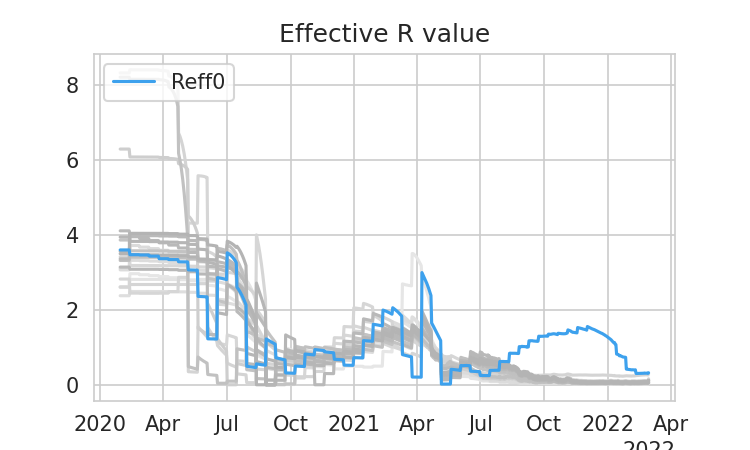

<IPython.core.display.Javascript object>


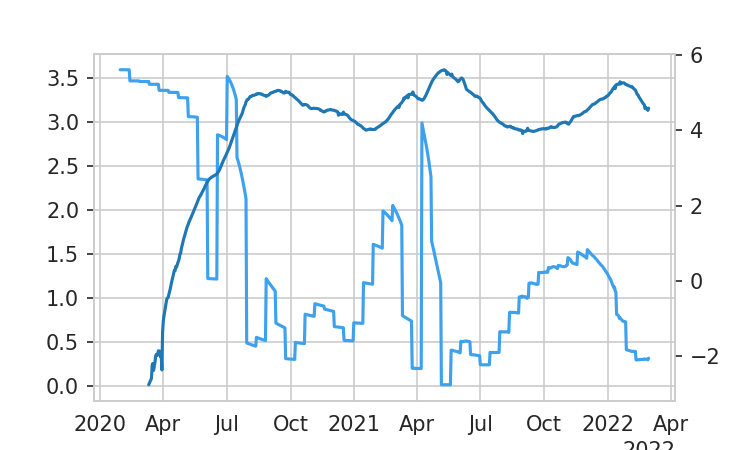

/home/savithru/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [338]:
pred_Reff = pred_data.filter(regex=("Reff.*"))
pred_reported = pred_data.filter(regex=("TotalR.*"))
print(pred_Reff)

plt.figure()

for i in range(num_sol_to_plot-1,0,-1):
    plt.plot(dates, pred_Reff["Reff"+str(i)], color=grey_colors[i])
plt.plot(dates, pred_Reff["Reff"+str(0)], color=grey_colors[0], label=pred_Reff.columns[0])

ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# labels = pred_Reff.columns[0:num_sol_to_plot][::-1].tolist();
plt.legend(loc='upper left')
plt.title('Effective R value')
plt.show()

plt.figure()
plt.plot(dates, pred_Reff["Reff0"], color=grey_colors[0])

ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax2 = ax.twinx()
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax2.plot(dates, np.log10(pred_reported["TotalR0"].diff()))
ax2.grid(None)
plt.show()

<IPython.core.display.Javascript object>


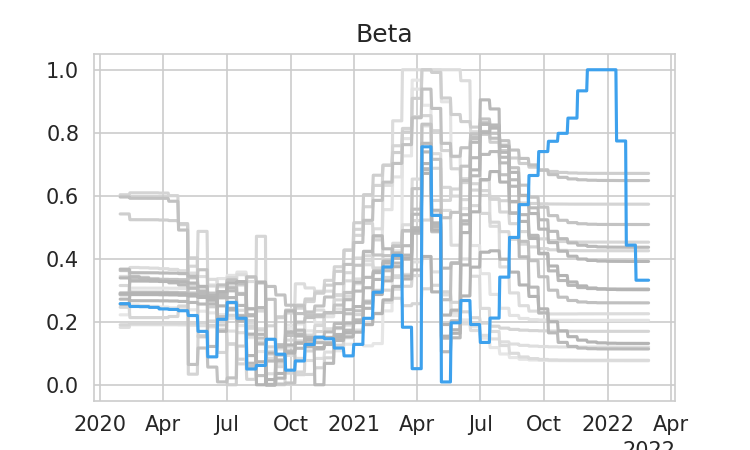

In [339]:
plt.figure()
for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, beta[i], color=grey_colors[i])
# sns.lineplot(data=beta,palette=grey_colormap, dashes=False)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.title('Beta')
plt.show()

<IPython.core.display.Javascript object>


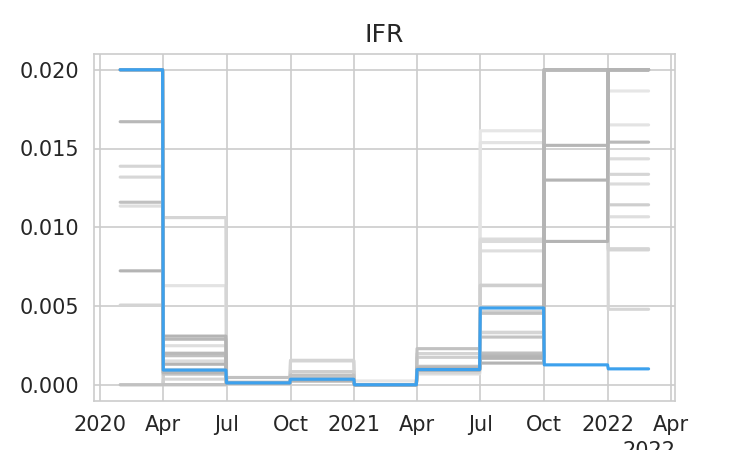

In [340]:
plt.figure()
for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, IFR[i], color=grey_colors[i])
# sns.lineplot(data=IFR,palette="ch:s=.25,rot=-.25,reverse=1", dashes=False)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.title('IFR')
plt.show()

In [105]:

err_t = (pred_data['TotalR0'] - smoothed_data["confirmed_smooth"])
err_f = (pred_data['FatalR0'] - smoothed_data["deaths_smooth"])
cost_t = np.linalg.norm(err_t)**2 / np.linalg.norm(smoothed_data["confirmed_smooth"])**2;
cost_f = np.linalg.norm(err_f)**2 / np.linalg.norm(smoothed_data["deaths_smooth"])**2
print(cost_t, cost_f, cost_t+cost_f)
#print(smoothed_data["confirmed_smooth"])

0.03648410056047015 0.0019618523035238723 0.03844595286399402


In [106]:
print(err_t)
print(format(np.linalg.norm(smoothed_data["confirmed_smooth"])**2, '1.8e'))
print(format(np.linalg.norm(smoothed_data["deaths_smooth"])**2, '1.8e'))

0     -1.000000e+00
1     -1.000000e+00
2     -2.000000e+00
3     -3.000000e+00
4     -4.000000e+00
           ...     
764   -2.426221e+07
765   -2.433000e+07
766   -2.439358e+07
767   -2.444436e+07
768   -2.451403e+07
Length: 769, dtype: float64
8.28461152e+17
1.99168674e+14
